# PARAMETRIC INSURANCE COVER IN SAN SALVADOR

This builds on the notebooks describing risk assessment [San Salvador Risk](San_Salvador_Risk.ipynb) and adaptation economics [San Salvador Adaptation](San_Salvador_Adaptation.ipynb) in San Salvador. In this section we will consider application of a parametric insurance cover at household level and combine with outcomes of the adaptation economics part.

## The working of a parametric insurance structure

Instead of using CLIMADA to evaluate risks, impacts, benefits of measures and indemnity insurance (as above), one can also assess parametric insurance. We apply the paramertric only to the AUP houses, with a maximum payout of 500 USD per household, starting at a flood height of 1m, with maximum payout at 5m, linear in between. First, read the Excel data where Value represents maximum payout and the impact function serves as payout structure.

In [1]:
%matplotlib inline
import numpy as np
import contextily as ctx
from climada.entity import Entity
import copy
import matplotlib.patches as patches
from climada.hazard import Hazard
from climada.engine import CostBenefit
import matplotlib.colors as colors
import contextily as ctx
from climada.engine import Impact

ent_2015_param = Entity()
ent_2015_param.read_excel('FL_entity_Acelhuate_parametric.xlsx')
ent_2015_param.exposures.ref_year = 2015 # fix reference year
ent_2015_param.check()

# flood as for 2015
HAZ_FILE = 'Salvador_hazard_FL_2015.mat'
haz_2015 = Hazard('FL')     # set hazard type
haz_2015.read_mat(HAZ_FILE) # load file

2019-12-19 15:14:18,275 - climada - DEBUG - Loading default config file: /Users/bresch/Documents/GitHub/climada_python/climada/conf/defaults.conf
2019-12-19 15:14:48,317 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2019-12-19 15:14:48,319 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2019-12-19 15:14:48,321 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2019-12-19 15:14:48,323 - climada.entity.exposures.base - INFO - centr_ not set.
2019-12-19 15:14:48,325 - climada.entity.exposures.base - INFO - category_id not set.
2019-12-19 15:14:48,328 - climada.entity.exposures.base - INFO - region_id not set.
2019-12-19 15:14:48,330 - climada.entity.exposures.base - INFO - geometry not set.
2019-12-19 15:14:48,336 - climada.hazard.base - INFO - Reading Salvador_hazard_FL_2015.mat
2019-12-19 15:14:48,506 - climada.hazard.centroids.centr - INFO - Reading Salvador

We now calculate the parametric insurance payout based on the AUP coordinates and the flood hazard:

2019-12-19 15:15:01,009 - climada.entity.exposures.base - INFO - Matching 6080 exposures with 153222 centroids.
2019-12-19 15:15:02,668 - climada.engine.impact - INFO - Calculating damage for 6080 assets (>0) and 6 events.
Annual expected payout: 19023.793763750018 USD


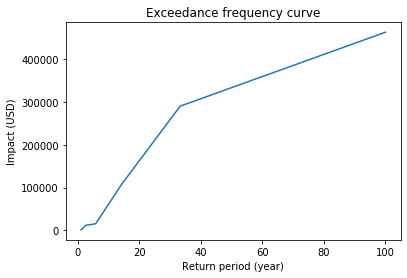

In [2]:
param_payout = Impact()
param_payout.calc(ent_2015_param.exposures, ent_2015_param.impact_funcs, haz_2015) # compute parametric payout
print('Annual expected payout: {:} USD'.format(param_payout.aai_agg)) # get average annual payout
param_payout.calc_freq_curve().plot() 

Now let's re-calculate some results we had in [San Salvador Adaptation](San_Salvador_Adaptation.ipynb). We need the combined effect of `Domestico` measures without application of (indemnity-based) insurance, as stored in `cb_comb` (contains the cost-benefit of combined measures):

In [3]:
ent_2015 = Entity()
ent_2015.read_excel('FL_entity_Acelhuate_houses.xlsx')
ent_2015.exposures.ref_year = 2015 # fix reference year
ent_2015.check()

ent_2040 = copy.deepcopy(ent_2015)

# Exposures: yearly economic growth of 2% in exposures
ent_2040.exposures.ref_year = 2040
growth = 0.02
ent_2040.exposures['value'] = ent_2040.exposures.value.values*(1 + growth)**(ent_2040.exposures.ref_year - ent_2015.exposures.ref_year)
ent_2040.check() # check values are well set and assignes default values

# flood as for 2040 with extreme climate change
HAZ_FILE = 'Salvador_hazard_FL_2040_extreme_cc.mat'
haz_2040 = Hazard('FL')     # set hazard type
haz_2040.read_mat(HAZ_FILE) # load file

# expected annual impact
cb_acel = CostBenefit()
cb_acel.calc(haz_2015, ent_2015, haz_2040, ent_2040, save_imp=True) # compute

cb_comb = cb_acel.combine_measures(['No descargas en Lluvia', 'Ahorradores en Agua en casas'],
                                    'Domestico', colors.to_rgb('lightcoral'), ent_2015.disc_rates)

2019-12-19 15:15:10,869 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2019-12-19 15:15:10,870 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2019-12-19 15:15:10,871 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2019-12-19 15:15:10,872 - climada.entity.exposures.base - INFO - centr_ not set.
2019-12-19 15:15:10,873 - climada.entity.exposures.base - INFO - category_id not set.
2019-12-19 15:15:10,875 - climada.entity.exposures.base - INFO - region_id not set.
2019-12-19 15:15:10,877 - climada.entity.exposures.base - INFO - geometry not set.
2019-12-19 15:15:10,891 - climada.entity.exposures.base - INFO - centr_ not set.
2019-12-19 15:15:10,892 - climada.entity.exposures.base - INFO - category_id not set.
2019-12-19 15:15:10,892 - climada.entity.exposures.base - INFO - region_id not set.
2019-12-19 15:15:10,893 - climada.entity.exposures.base - INFO - geo

We can now calculate the damage left after application of the `Domestico` measures (`damage_after_measures`) PLUS the payout of the parametric cover (`parametric_payout`) for AUP houses:

In [4]:
damage_after_measures=cb_comb.imp_meas_present['Domestico']['impact'].at_event
paramteric_payout=param_payout.at_event
residual_damage=np.sum((damage_after_measures-paramteric_payout)*haz_2015.frequency)
print('residual damage: {:.3e} USD'.format(residual_damage))

residual damage: 2.527e+06 USD
